# Systems genetics 2020 - Final Project  

#### Note!
Our project is devided into several python modules which are loaded and excecuted from this notebook. <br>
Most of our code's project can be found under the /modules directory. 

Import public packges

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import f
import matplotlib.pyplot as plt
import os.path
import seaborn as sns
import sys
from scipy import stats 
import warnings
warnings.filterwarnings('ignore')

Import custom packges (our python modules)

In [2]:
sys.path.append('modules')

from utils import print_dim, print_stats
from preprocessing import data_annotations_merge
from regression import eqtl_analysis, qtl_analysis
from results_analysis import get_associations, cis_trans_annotation
from causality_analysis import causality_analysis
from visualizations import plot_associated_genes_per_eqtl, plot_association_pval_dist, plot_summary_visualization

In [3]:
bold_s = '\033[1m'
bold_e = '\033[0m'

Load data files

In [4]:
liver_exp = pd.read_csv('data/GSE17522_series_matrix_liver.txt', sep = "\t")
brain_exp = pd.read_csv('data/GSE36674_series_matrix_hypothalamus.txt', sep = "\t")

liver_annotations = pd.read_csv('data/annotations_liver_GPL6466-9752.txt', sep = "\t")
brain_annotations = pd.read_csv('data/annotation_brain.annot', sep = "\t")

genotypes = pd.read_excel('data/genotypes.xls', headers=None)
phenotypes = pd.read_excel('data/phenotypes.xls')

mgi = pd.read_csv('data/MGI_Coordinates.Build37.rpt.txt', sep = "\t", error_bad_lines=False, warn_bad_lines=False)

## Part 2: Gene expression data preprocessing

#### A. Merge data file with annotation file to get your input matrix

Brain

In [5]:
brain_annotations = brain_annotations.rename(columns={'Gene symbol' : 'GENE_SYMBOL'})
brain_matrix = data_annotations_merge(brain_exp, brain_annotations)

Liver

In [6]:
liver_matrix = data_annotations_merge(liver_exp, liver_annotations)

# Keep BXD columns and identifier columns only
liver_bxd_cols = list(liver_matrix.filter(regex=("BXD*")).columns)
id_cols = ['ID', 'GENE_SYMBOL']
liver_matrix = liver_matrix[id_cols + liver_bxd_cols]

# Rename BXD columns
liver_matrix = liver_matrix.rename(columns={col : col.split('_')[1] + '_' + col.split('_')[2] \
                                            for col in liver_matrix.columns.drop(id_cols)})

#### B. Keep only BXD columns that exists in all files: genotypes, phenotypes and tissue

In [7]:
genotypes_bxd_cols = list(genotypes.filter(regex=("BXD*")).columns)
phenotypes_bxd_cols = list(phenotypes.filter(regex=("BXD*")).columns)

genotypes_baseline_cols = ["Locus", "Chr_Build37", "Build37_position"]
phenotypes_baseline_cols = ["Phenotype", "Authors", "Year", "Pubmed Id"]

# liver common columns
liver_matrix = liver_matrix.rename(columns = {col : col.split('_')[0] for col in liver_matrix.drop(columns = id_cols)}) 
liver_bxd_cols = list(liver_matrix.filter(regex='BXD').columns)
liver_common_bxd = list(set(genotypes_bxd_cols) & set(phenotypes_bxd_cols) &  set(liver_bxd_cols))
liver_common_bxd.sort()
liver_matrix = liver_matrix[['GENE_SYMBOL'] + liver_common_bxd]
liver_genotypes = genotypes[genotypes_baseline_cols + liver_common_bxd]
liver_phenotypes = phenotypes[phenotypes_baseline_cols + liver_common_bxd]

# brain common columns
brain_matrix = brain_matrix.rename(columns = {col : col.split('_')[0] for col in brain_matrix.drop(columns = id_cols)}) 
brain_bxd_cols = list(brain_matrix.filter(regex='BXD').columns)
brain_common_bxd = list(set(genotypes_bxd_cols) & set(phenotypes_bxd_cols) &  set(brain_bxd_cols))
brain_common_bxd.sort()
brain_matrix = brain_matrix[['GENE_SYMBOL'] + brain_common_bxd]
brain_genotypes = genotypes[genotypes_baseline_cols + brain_common_bxd]
brain_phenotypes = phenotypes[phenotypes_baseline_cols + brain_common_bxd]

# drop empty lines from phenotypes file
brain_phenotypes = brain_phenotypes.iloc[brain_phenotypes[brain_common_bxd].dropna(how='all').index]
liver_phenotypes = liver_phenotypes.iloc[liver_phenotypes[liver_common_bxd].dropna(how='all').index]

#### C. Use only representative genomic loci - Drop duplicated rows (of neighboring loci)

In [8]:
# liver genotypes filtering
snps_org = len(liver_genotypes)
bxd_data = liver_genotypes[liver_common_bxd]
duplicates_indx = bxd_data[bxd_data.shift() != bxd_data].dropna(how='all').index
liver_genotypes = liver_genotypes.loc[duplicates_indx]
print("LIVER Genotypes: Drop duplications:\n#SNPs before: %d   -->   #SNPs after: %d" % (snps_org, len(liver_genotypes)))

# Brain genotypes filtering
snps_org = len(brain_genotypes)
bxd_data = brain_genotypes[brain_common_bxd]
duplicates_indx = bxd_data[bxd_data.shift() != bxd_data].dropna(how='all').index
brain_genotypes = brain_genotypes.loc[duplicates_indx]
print("\nBRAIN Genotypes: Drop duplications:\n#SNPs before: %d   -->   #SNPs after: %d" % (snps_org, len(brain_genotypes)))

LIVER Genotypes: Drop duplications:
#SNPs before: 3796   -->   #SNPs after: 1403

BRAIN Genotypes: Drop duplications:
#SNPs before: 3796   -->   #SNPs after: 1598


#### • Remove rows with no gene identifier, <br> • Remove rows with low maximal value.  <br> • Remove rows with low variance.  <br> • Average multiple rows


Liver

Num of rows in liver expression file:  20868
Num of rows after removing rows with no gene identifier:  19272
Num of rows after removing all rows with maximal values less than 0.70: 7772 


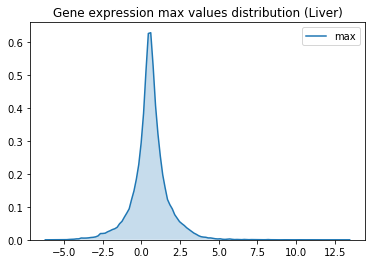

Num of rows after removing all rows with variance less than 0.20: 1308 


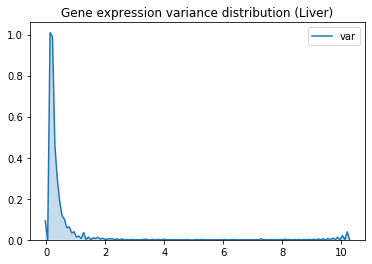

Num of rows after removing duplicated rows: %d  1285


In [9]:
max_treshold = 0.7
var_treshold = 0.2

# Remove rows with no gene identifier
print("Num of rows in liver expression file: ", len(liver_matrix))
liver_matrix = liver_matrix[~liver_matrix['GENE_SYMBOL'].isna()]
print("Num of rows after removing rows with no gene identifier: ", len(liver_matrix))

liver_bxd_cols = list(liver_matrix.filter(regex=("BXD*")).columns)
for col in liver_bxd_cols:
    liver_matrix[col] = liver_matrix[col].astype('float64')

# Filter by maximal value
liver_matrix['max'] = liver_matrix.drop(columns=['GENE_SYMBOL']).max(axis=1)
sns.kdeplot(liver_matrix['max'], shade=True).set_title('Gene expression max values distribution (Liver)')
liver_matrix = liver_matrix[liver_matrix['max'] >= max_treshold]
liver_matrix = liver_matrix.drop(columns = 'max')
print("Num of rows after removing all rows with maximal values less than %.2f: %d " % (max_treshold, len(liver_matrix)))
plt.show()

# Filter by variance
liver_matrix['var'] = liver_matrix.drop(columns=['GENE_SYMBOL']).var(axis=1)
sns.kdeplot(liver_matrix['var'], shade=True).set_title('Gene expression variance distribution (Liver)')
liver_matrix = liver_matrix[liver_matrix['var'] >= var_treshold]
liver_matrix = liver_matrix.drop(columns = 'var')
print("Num of rows after removing all rows with variance less than %.2f: %d " % (var_treshold, len(liver_matrix)))
plt.show()

# Group multiple rows by mean
liver_matrix = liver_matrix.groupby('GENE_SYMBOL').agg('mean').reset_index()
print("Num of rows after removing duplicated rows: %d ", len(liver_matrix))

Brain

Num of rows in brain expression file:  27365
Num of rows after removing rows with no gene identifier:  21512
Num of rows after removing all rows with maximal values less than 9.00: 9893 


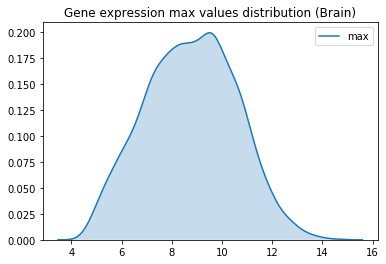

Num of rows after removing all rows with variance less than 0.04: 1444 


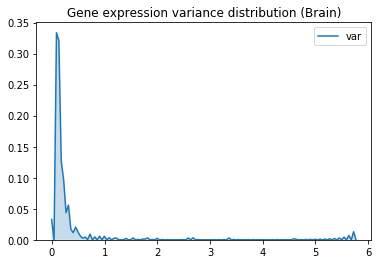

Num of rows after removing duplicated rows: %d  1247


In [10]:
max_treshold = 9
var_treshold = 0.04

# Remove rows with no gene identifier
print("Num of rows in brain expression file: ", len(brain_matrix))
brain_matrix = brain_matrix[~brain_matrix['GENE_SYMBOL'].isna()]
print("Num of rows after removing rows with no gene identifier: ", len(brain_matrix))

brain_bxd_cols = list(brain_matrix.filter(regex=("BXD*")).columns)
for col in brain_bxd_cols:
    brain_matrix[col] = brain_matrix[col].astype('float64')
    
# Filter by maximal value
brain_matrix['max'] = brain_matrix.drop(columns=['GENE_SYMBOL']).max(axis=1)
sns.kdeplot(brain_matrix['max'], shade=True).set_title('Gene expression max values distribution (Brain)')
brain_matrix = brain_matrix[brain_matrix['max'] >= max_treshold]
brain_matrix = brain_matrix.drop(columns = 'max')
print("Num of rows after removing all rows with maximal values less than %.2f: %d " % (max_treshold, len(brain_matrix)))
plt.show()

# Filter by variance
brain_matrix['var'] = brain_matrix.drop(columns=['GENE_SYMBOL']).var(axis=1)
sns.kdeplot(brain_matrix['var'], shade=True).set_title('Gene expression variance distribution (Brain)')
brain_matrix = brain_matrix[brain_matrix['var'] >= var_treshold]
brain_matrix = brain_matrix.drop(columns = 'var')
print("Num of rows after removing all rows with variance less than %.2f: %d " % (var_treshold, len(brain_matrix)))
plt.show()

# Group multiple rows by mean
brain_matrix = brain_matrix.groupby('GENE_SYMBOL').agg('mean').reset_index()
print("Num of rows after removing duplicated rows: %d ", len(brain_matrix))

#### • Average across different individuals of the same strain (Females and males)

In [11]:
liver_matrix = liver_matrix.rename(columns = {col : col.split('_')[0] for col in liver_matrix.drop(columns = ['GENE_SYMBOL'])}) 
liver_matrix = liver_matrix.set_index(['GENE_SYMBOL']) 
liver_matrix = liver_matrix.groupby(by=liver_matrix.columns, axis=1).mean()
liver_matrix = liver_matrix.reset_index()

brain_matrix = brain_matrix.rename(columns = {col : col.split('_')[0] for col in brain_matrix.drop(columns = ['GENE_SYMBOL'])}) 
brain_matrix = brain_matrix.set_index(['GENE_SYMBOL']) 
brain_matrix = brain_matrix.groupby(by=brain_matrix.columns, axis=1).mean()
brain_matrix = brain_matrix.reset_index()

## Part 3: eQTL analysis

#### Run  Regression

In [12]:
print_dim(len(liver_matrix), len(liver_genotypes), title="Liver: ")
print_dim(len(brain_matrix), len(brain_genotypes), title="Brain: ")

Liver: 
* Expression matrix size: 1285
* Genotype matrix size: 1403
* Expected num of tests: 1,802,855

Brain: 
* Expression matrix size: 1247
* Genotype matrix size: 1598
* Expected num of tests: 1,992,706



In [13]:
# Brain eqtl
if not os.path.exists("output/brain_reg_results.csv"):
    brain_eqtls = eqtl_analysis(brain_matrix, brain_genotypes, file_prefix="brain_")
else:
    brain_eqtls = pd.read_csv("output/brain_reg_results.csv")
    brain_eqtls = brain_eqtls.drop(columns='Unnamed: 0')
    
# Liver eqtl
if not os.path.exists("output/liver_reg_results.csv"):
    liver_eqtls = eqtl_analysis(liver_matrix, liver_genotypes, file_prefix="liver_")
else:
    liver_eqtls = pd.read_csv("output/liver_reg_results.csv")
    liver_eqtls = liver_eqtls.drop(columns='Unnamed: 0')

#### Cis/Trans annotation

In [14]:
brain_eqtls = cis_trans_annotation(brain_eqtls.copy(), mgi)
liver_eqtls = cis_trans_annotation(liver_eqtls.copy(), mgi)

100%|██████████████████████████████████████████████████████████████████████████████| 1285/1285 [13:21<00:00,  1.60it/s]


#### Multiple test correction and associations filtering

In [15]:
brain_associations, brain_num_tests, brain_alpha = get_associations(brain_eqtls) # by bonfferoni corrections
brain_assoc_snps = list(brain_associations['SNP'].unique())
brain_associations.to_csv("output/brain_assoc_eqtl.csv")

liver_associations, liver_num_tests, liver_alpha = get_associations(liver_eqtls) # by bonfferoni corrections
liver_assoc_snps = list(liver_associations['SNP'].unique())
liver_associations.to_csv("output/liver_assoc_eqtl.csv")

print_stats(brain_associations, brain_num_tests, brain_alpha, "1. Brain")
print_stats(liver_associations, liver_num_tests, liver_alpha, "\n\n2. Liver")

1. Brain
Number of tests:  1992706
alpha after correction:  2.509150873234687e-08

Number of different significant eQTLs:  472
260 - unique cis-acting 
 231 - unique trans-acting 

Number of total significant eQTLs:  868
From which: 
 349 - cis-acting 
 337 - trans-acting 
 182 - Unknowns


2. Liver
Number of tests:  1802855
alpha after correction:  2.7733788907039114e-08

Number of different significant eQTLs:  481
261 - unique cis-acting 
 278 - unique trans-acting 

Number of total significant eQTLs:  840
From which: 
 325 - cis-acting 
 468 - trans-acting 
 47 - Unknowns


#### Brain Plots

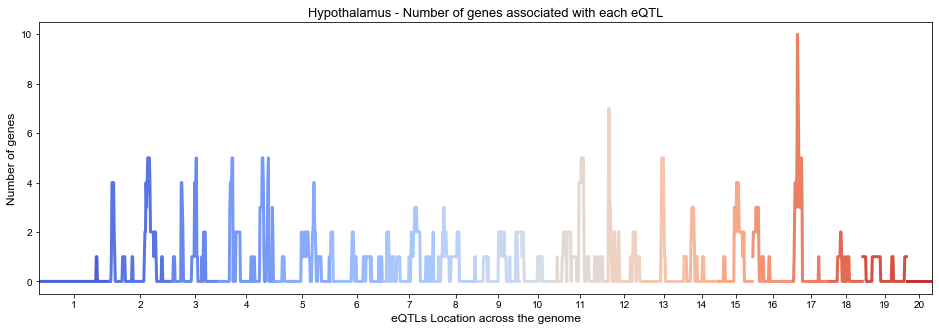

,Locus,chromosome,num_genes,index
1019,rs3657682,12,7.0,1019
1020,rs6180964,12,7.0,1020
1357,CEL-17_21879142,17,10.0,1357
1358,rs13482930,17,8.0,1358


In [16]:
brain_gene_cnt = plot_associated_genes_per_eqtl(brain_associations, brain_genotypes, tissue_str="Hypothalamus - ")
brain_gene_cnt[brain_gene_cnt['num_genes']>6]

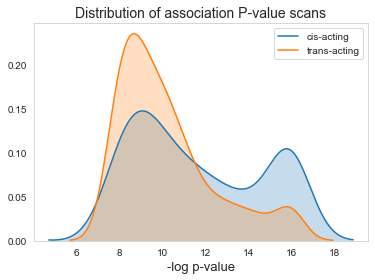

In [17]:
plot_association_pval_dist(brain_associations)

In [18]:
# plot_summary_visualization(brain_eqtls, mgi, treshold=brain_alpha, tissue_str="Brain - ")
# plot_summary_visualization(brain_eqtls, mgi, treshold=0.001, tissue_str="Brain - ")

#### Liver Plots

In [27]:
liver_gene_cnt = plot_associated_genes_per_eqtl(liver_associations, liver_genotypes, tissue_str="Liver - ")
liver_gene_cnt[liver_gene_cnt['num_genes']>=7]

,Locus,chromosome,num_genes,index
514,rs13479023,6,7.0,514
515,rs3681620,6,8.0,515
518,rs13479053,6,7.0,518
519,rs13479065,6,7.0,519
938,rs13481620,12,11.0,938
939,rs8273308,12,10.0,939


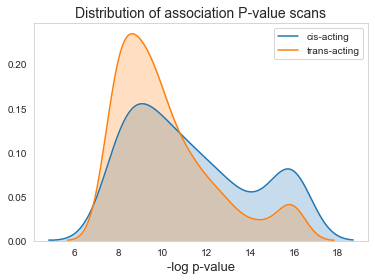

In [20]:
plot_association_pval_dist(liver_associations)

In [21]:
# plot_summary_visualization(liver_eqtls, mgi, treshold=liver_alpha, tissue_str="Liver - ")
# plot_summary_visualization(liver_eqtls, mgi, treshold=0.001, tissue_str="Liver - ")

### Part 4: QTL analysis

In [22]:
phenotype_subset_brain = brain_phenotypes[brain_phenotypes['Phenotype'].str.contains("TNF")]
phenotype_subset_liver = liver_phenotypes[liver_phenotypes['Phenotype'].str.contains("TNF")]
print("The selected phenotypes are:\n", phenotype_subset_brain['Phenotype'].unique())

The selected phenotypes are:
 ['Tumor necrosis factor (TNF)-alpha level in lung after aerosolized lipopolysaccharide (LPS) exposure [pg/ml]'
 'Immune function: tumor necrosis factor (TNF)-induced hypothermia [degree C]'
 'Tumor necrosis factor (TNF) lethal shock, induction of serum interleukin 6 (IL-6) cytokine after injection [ng/ml]'
 'Immune function: Lethality due to tumor necrosis factor (TNF) injection [%]'
 'Infectious disease, immune function: Cytotoxic T-cell (CTL) response (5 x 10^9 PFU AdLacZ iv), measured as tumor necrosis factor alpha (TNFa) cytokine expression [pg/ml]\r\n']


In [23]:
logpval_brain = qtl_analysis(phenotype_subset_brain, brain_genotypes, file_prefix="brain_")
logpval_liver = qtl_analysis(phenotype_subset_liver, liver_genotypes, file_prefix="liver_")

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:19<00:00, 15.90s/it]


In [24]:
assoc_qtl_b, ntests_qtl_b, alpha_b = get_associations(logpval_brain) # by bonfferoni corrections
assoc_qtl_l, ntests_qtl_l, alpha_l = get_associations(logpval_liver) # by bonfferoni corrections

### Part 6: Causality Test

Liver

Selected triplet for causality analysis:
1. Locus (L): rs13481620
2. Gene expression (R): 4930465A12Rik
3. Phenotype (C): Tumor necrosis factor (TNF) lethal shock, induction of serum interleukin 6 (IL-6) cytokine after injection [ng/ml]

Causality Analusis Results:
The best model is: M 3
The Likelihood-Ratio is: 63.89


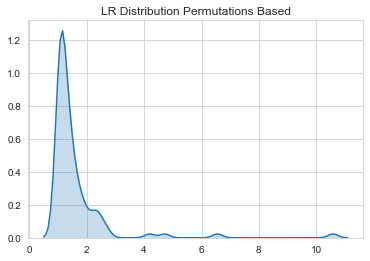

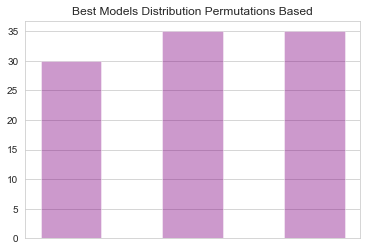

The are 0 LR values that are greater than our LR
Our LR is significant with p-value of  0.01
------------------------------------------------------------
Selected triplet for causality analysis:
1. Locus (L): rs8273308
2. Gene expression (R): Hnf4g
3. Phenotype (C): Tumor necrosis factor (TNF) lethal shock, induction of serum interleukin 6 (IL-6) cytokine after injection [ng/ml]

Causality Analusis Results:
The best model is: M 3
The Likelihood-Ratio is: 18.99


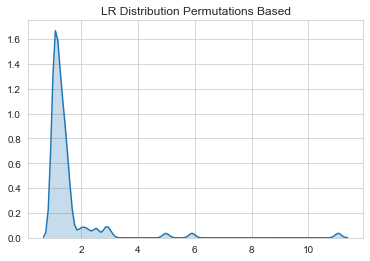

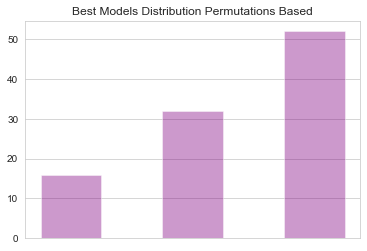

The are 0 LR values that are greater than our LR
Our LR is significant with p-value of  0.01
------------------------------------------------------------
Selected triplet for causality analysis:
1. Locus (L): rs8273308
2. Gene expression (R): 4930465A12Rik
3. Phenotype (C): Immune function: Lethality due to tumor necrosis factor (TNF) injection [%]

Causality Analusis Results:
The best model is: M 3
The Likelihood-Ratio is: 175.00


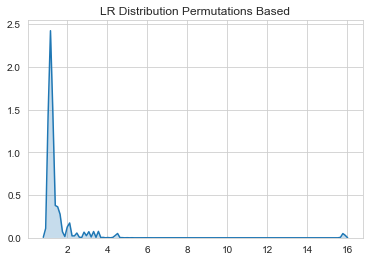

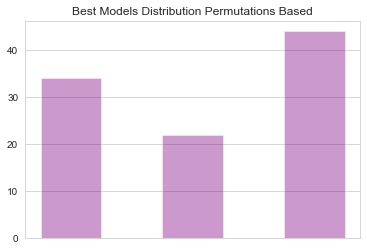

The are 0 LR values that are greater than our LR
Our LR is significant with p-value of  0.01
------------------------------------------------------------


In [25]:
# Out Liver triplets for analysis (L, R, C) 
triple_indices = [(2617, 60, 371),   # rs13481620 | 4930465A12Rik      
                  (2620, 594, 371),   # rs8273308 | Hnf4g
                  (2620, 60, 372)]   # rs8273308  | 4930465A12Rik

for trio in triple_indices:
    # Choose a triplet L, R, C for the causality analysis
    locus_idx, gene_exp_idx, phenotype_idx = trio

    locus = liver_genotypes.loc[[locus_idx]].replace({'B': 0, 'b': 0, 'D':1, 'H': np.nan, 'U': np.nan})[liver_common_bxd]
    gene_exp = liver_matrix.loc[[gene_exp_idx]][liver_common_bxd]
    phenotype = liver_phenotypes.loc[[phenotype_idx]][liver_common_bxd]

    print((bold_s + "Selected triplet for causality analysis:\n1. Locus (L): %s\n2. Gene expression (R): %s\n3. Phenotype (C): %s" + bold_e)
         % (liver_genotypes.loc[locus_idx]['Locus'],
            liver_matrix.loc[gene_exp_idx]['GENE_SYMBOL'],
            liver_phenotypes.loc[phenotype_idx]['Phenotype']))

    # Run analysis
    print("\nCausality Analusis Results:")
    LR, best_model, LR_dist, model_dist, pval = causality_analysis(locus, gene_exp, phenotype)
    print("------------------------------------------------------------")

Brain

Selected triplet for causality analysis:
1. Locus (L): rs8273308
2. Gene expression (R): Serpina3n
3. Phenotype (C): Immune function: Lethality due to tumor necrosis factor (TNF) injection [%]

Causality Analusis Results:
The best model is: M 3
The Likelihood-Ratio is: 1.81


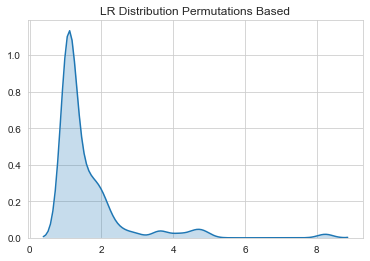

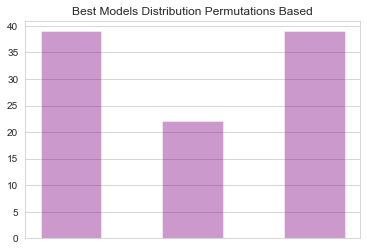

The are 22 LR values that are greater than our LR
Our LR is not significant. p-value= 0.23
------------------------------------------------------------


In [26]:
# Out Brain triplets for analysis (L, R, C) 
brain_trio_idx = [(2620, 997, 372)] # rs8273308   | Serpina3n

for trio in brain_trio_idx:
    # Choose a triplet L, R, C for the causality analysis
    locus_idx, gene_exp_idx, phenotype_idx = trio

    locus = brain_genotypes.loc[[locus_idx]].replace({'B': 0, 'b': 0, 'D':1, 'H': np.nan, 'U': np.nan})[brain_common_bxd]
    gene_exp = brain_matrix.loc[[gene_exp_idx]][brain_common_bxd]
    phenotype = brain_phenotypes.loc[[phenotype_idx]][brain_common_bxd]

    print((bold_s + "Selected triplet for causality analysis:\n1. Locus (L): %s\n2. Gene expression (R): %s\n3. Phenotype (C): %s" + bold_e)
         % (brain_genotypes.loc[locus_idx]['Locus'],
            brain_matrix.loc[gene_exp_idx]['GENE_SYMBOL'],
            brain_phenotypes.loc[phenotype_idx]['Phenotype']))

    # Run analysis
    print("\nCausality Analusis Results:")
    LR, best_model, LR_dist, model_dist, pval = causality_analysis(locus, gene_exp, phenotype)
    print("------------------------------------------------------------")